https://towardsdatascience.com/a-complete-guide-to-recommender-system-tutorial-with-sklearn-surprise-keras-recommender-5e52e8ceace1

https://colab.research.google.com/drive/1w92d6_BjrF5nVLoFhD1Oa6dV3DgKra8G?usp=sharing#scrollTo=4tMRNY6LB8zZ

In [16]:
from collections import defaultdict
from typing import Dict, Text, Tuple
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

from surprise import SVD, accuracy
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection.split import train_test_split

import tensorflow as tf
import tensorflow_recommenders as tfrs
from tensorflow import keras as keras
from sklearn.model_selection import train_test_split

# We need python 3.6 - 3.8 to use "recommenders" microsoft library
"""
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.utils.constants import SEED as DEFAULT_SEED
"""

'\nfrom recommenders.models.ncf.ncf_singlenode import NCF\nfrom recommenders.models.ncf.dataset import Dataset as NCFDataset\nfrom recommenders.datasets.python_splitters import python_chrono_split\nfrom recommenders.utils.constants import SEED as DEFAULT_SEED\n'

In [3]:
print(10_0_0) # curious

1000


In [4]:
# init constant
USER_COL = 'user_id'
ITEM_COL = 'item_id'
RATING_COL = 'rating'

# synthesize data
NUM_USERS = 10000
NUM_ITEMS = 1000
user_id = np.arange(start = 0, stop = NUM_USERS)
item_id = np.arange(start = 0, stop = NUM_ITEMS)
np.random.seed(42)

user_item_dict = defaultdict(list)
genres = ['Action','Comedy','Drama','Fantasy','Horror','Mystery','Romance','Thriller','Western']
for id in user_id:
    
    # random the number of item generation
    # for each user, random 3 to 5 items to be rated.
    num_rand_item = np.random.randint(low = 3, high = 5)

    # random from the item_id
    rand_items = np.random.choice(item_id, size = num_rand_item, replace = False)

    # random rating for each itme_id
    rand_rating = np.random.randint(low = 1, high = 10, size = num_rand_item)

    # collect the user-item paris.
    for uid, iid, rating in zip([id] * num_rand_item, rand_items, rand_rating):
        user_item_dict[USER_COL].append(uid)
        user_item_dict[ITEM_COL].append(iid)
        user_item_dict[RATING_COL].append(rating)

# prepare dataframe
ratings = pd.DataFrame(user_item_dict)
print("Rating Dataframe")
ratings[['user_id','item_id']] = ratings[['user_id','item_id']].astype(str)
display(ratings.head())

item_genre_dict = defaultdict(list)
for iid in item_id:

    # random number of genres
    num_rand_genre = np.random.randint(low = 1, high = 3)
    # random set of genres
    rand_genres = np.random.choice(genres, size = num_rand_genre, replace = False)
    item_genre_dict['item_id'].append(iid)
    item_genre_dict['genres'].append(', '.join(list(rand_genres)))

# prepare dataframe
items = pd.DataFrame(item_genre_dict)
print("\nItem Dataframe")
items = items.astype(str)
display(items.head())

Rating Dataframe


,user_id,item_id,rating
0,0,521,2
1,0,941,8
2,0,741,2
3,1,986,5
4,1,275,5



Item Dataframe


,item_id,genres
0,0,"Romance, Action"
1,1,Mystery
2,2,"Drama, Western"
3,3,"Fantasy, Horror"
4,4,"Comedy, Drama"


### 1. Popular based (Baseline model)

Is the unique **non-personalized** approach. The rest are personalized for each user.

Baseline model, to use as reference whether our approach is good or not.



We get the top with highest average rating or to use some more sophisticated heuristic

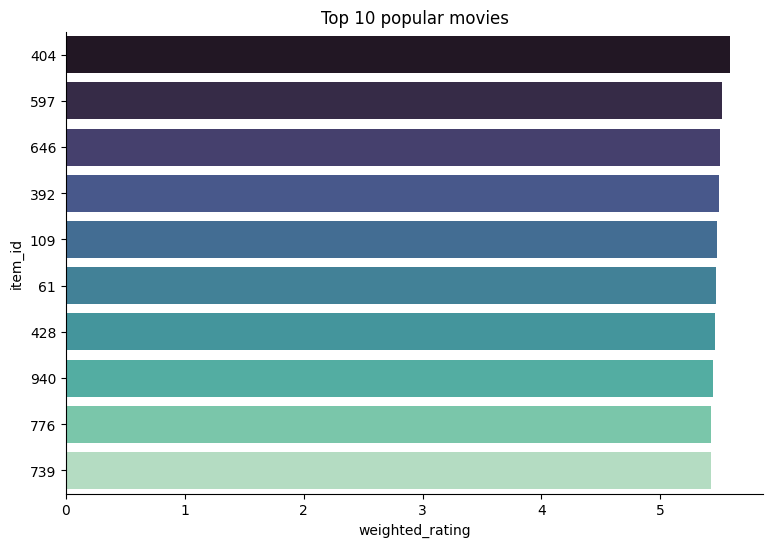

In [5]:
def weighted_rating(v,m,R,C):
    '''
    Calculate the IMDB weighted rating system: 
        WR = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
    
    Args:
    v -> average rating for each item (float)
    m -> minimum votes required to be classified as popular defined by
     percentile 80 of total votes (float)
    R -> average rating for the item (pd.Series)
    C -> average rating for the whole dataset (pd.Series)
    
    Returns:
    pd.Series
    '''
    return ( (v / (v + m)) * R) + ( (m / (v + m)) * C )

def assign_popular_based_score(rating_df, item_df):
    '''
    Assigned popular based score based on the IMDB weighted average.
    
    Args:
    rating -> pd.DataFrame contains ['item_id', 'rating'] for each user.
    
    Returns
    popular_items -> pd.DataFrame contains item and IMDB weighted score.
    '''
    
    # pre processing
    vote_count = (rating_df
        .groupby(ITEM_COL, as_index=False)
        .agg({USER_COL:'count', RATING_COL:'mean'} )
        )
    vote_count.columns = [ITEM_COL, 'vote_count', 'avg_rating']
    
    # calculate input parameters
    C = np.mean(vote_count['avg_rating'])
    m = np.percentile(vote_count['vote_count'], 70) # in the descrition it says 80
    vote_count = vote_count[vote_count['vote_count'] >= m]
    R = vote_count['avg_rating']
    v = vote_count['vote_count']

    vote_count['weighted_rating'] = weighted_rating(v,m,R,C)
    
    # post processing
    vote_count = vote_count.merge(item_df, on = [ITEM_COL], how = 'left')
    popular_items = vote_count.loc[:,[ITEM_COL, 'genres', 'vote_count', 'avg_rating', 'weighted_rating']]
    
    return popular_items

# calcualte popularity based
pop_items = assign_popular_based_score(ratings, items)
pop_items = pop_items.sort_values('weighted_rating', ascending = False)

# plot the popularity based on the weighted score
fix, ax = plt.subplots(figsize=(9,6))
plt.title("Top 10 popular movies")
sns.barplot(data = pop_items.head(10),
            y = 'item_id',
            x = 'weighted_rating',
            palette = 'mako');
sns.despine()

### 2. Content-based (Filtering)

To recommend items similars for a user, given its historical.

Another approach can be a TF-IDF, to recommend items with unpopular genres

In [6]:
def top_k_items(item_id, top_k, corr_mat, map_name):
    
    # sort correlation value ascendingly and select top_k item_id
    top_items = corr_mat[item_id,:].argsort()[-top_k:][::-1] 
    top_items = [map_name[e] for e in top_items] 

    return top_items

# preprocessing, get items with at least one rating
rated_items = items.loc[items[ITEM_COL].isin(ratings[ITEM_COL])].copy()

# extract the genre
genre = rated_items['genres'].str.split(",", expand=True)

# get all possible genre
all_genre = set()
for c in genre.columns:
    distinct_genre = genre[c].str.lower().str.strip().unique()
    all_genre.update(distinct_genre)
all_genre.remove(None)

# create item-genre matrix
item_genre_mat = rated_items[[ITEM_COL, 'genres']].copy()
item_genre_mat['genres'] = item_genre_mat['genres'].str.lower().str.strip()

# OHE the genres column
for genre in all_genre:
    item_genre_mat[genre] = np.where(item_genre_mat['genres'].str.contains(genre), 1, 0)
item_genre_mat = item_genre_mat.drop(['genres'], axis=1)
item_genre_mat = item_genre_mat.set_index(ITEM_COL)

# compute similarity matix
corr_mat = cosine_similarity(item_genre_mat)

# get top-k similar items
ind2name = {ind:name for ind,name in enumerate(item_genre_mat.index)}
name2ind = {v:k for k,v in ind2name.items()}
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = corr_mat,
                            map_name = ind2name)

# display result
print("The top-k similar movie to item_id 99")
display(items.loc[items[ITEM_COL].isin(similar_items)])

del corr_mat
gc.collect();

The top-k similar movie to item_id 99


,item_id,genres
0,0,"Romance, Action"
99,99,"Romance, Action"
211,211,"Romance, Action"
352,352,"Romance, Action"
512,512,"Action, Romance"
618,618,"Romance, Action"
737,737,"Action, Romance"
744,744,"Romance, Action"
813,813,"Action, Romance"
858,858,"Romance, Action"


### 3. Collaborative filtering

To fix cold start we can:
* new user: recommend the most popular
* new item: recommend using content_based approach

#### 3.1 Memory based

Memory based is called like that beacuse "memorize" all interactions between users, and predict without use a model.

The inconvenient is that the matrix can be very sparse, leading to poor generalization

##### 3.1.1 User-based

In [7]:
# preprocess data
row = ratings[USER_COL]
col = ratings[ITEM_COL]
data = ratings[RATING_COL]

# init user-item matrix
mat = csr_matrix((data, (row, col)), shape=(NUM_USERS, NUM_ITEMS))
mat.eliminate_zeros()

# calculate sparsity
sparsity = float(len(mat.nonzero()[0]))
sparsity /= (mat.shape[0] * mat.shape[1])
sparsity *= 100
print(f'Sparsity: {sparsity:4.2f}%. This means that {sparsity:4.2f}% of the user-item ratings have a value.')

# compute similarity
item_corr_mat = cosine_similarity(mat.T)

# get top k item
print("\nThe top-k similar movie to item_id 99")
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = item_corr_mat,
                            map_name = ind2name)

display(items.loc[items[ITEM_COL].isin(similar_items)])

Sparsity: 0.35%. This means that 0.35% of the user-item ratings have a value.

The top-k similar movie to item_id 99


,item_id,genres
99,99,"Romance, Action"
248,248,Horror
352,352,"Romance, Action"
392,392,"Romance, Action"
507,507,"Horror, Western"
570,570,Horror
730,730,Fantasy
757,757,"Romance, Thriller"
824,824,Fantasy
899,899,Comedy


I think that example has a bad explanation. Is user-based, but the recommendation don't follow the steps that author said.

##### 3.1.2 Item-based

#### 3.2 Model based

**Introduction**

Model-based CF uses machine learning algorithms to predict users’ rating of unrated items. 
There are many model-based CF algorithms, the most commonly used are matrix factorization models such as to applying a SVD to reconstruct the rating matrix, latent Dirichlet allocation or Markov decision process based models. Building a memory based collaborative filtering recommender

**Type**

- Matrix Factorization (MF) based
    1. TruncatedSVD (Sklearn)
    2. Funk MF (Surprise)
- Deep learning MF based
    1. Generalizaed MF (Keras)
    2. Neural Collaborative filtering (Recommenders)

##### 3.2.1 Matrix Factorization

##### 3.2.1.1 TrucantedSVD (Sklearn)

In [8]:
'''
the user_item_matrix will look like this
|        | item 1 | ... | item m |
|--------|--------|-----|--------|
| user 1 | 3      | 0   | 0      |
| ...    | 0      | 4   | 5      |
| user n | 2      | 0   | 0      |
'''

# initial hyperparameter
epsilon = 1e-9
n_latent_factors = 10

# calculate item latent matrix
item_svd = TruncatedSVD(n_components = n_latent_factors)
item_features = item_svd.fit_transform(mat.transpose()) + epsilon

# calculate user latent matrix
user_svd = TruncatedSVD(n_components = n_latent_factors)
user_features = user_svd.fit_transform(mat) + epsilon

# compute similarity
item_corr_mat = cosine_similarity(item_features)

# get top k item
print("\nThe top-k similar movie to item_id 99")
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = item_corr_mat,
                            map_name = ind2name)

display(items.loc[items[ITEM_COL].isin(similar_items)])

del user_features


The top-k similar movie to item_id 99


,item_id,genres
75,75,Romance
90,90,"Action, Fantasy"
99,99,"Romance, Action"
359,359,"Horror, Mystery"
521,521,Thriller
568,568,Romance
629,629,Thriller
802,802,"Mystery, Action"
832,832,Action
885,885,Romance


##### 3.2.1.2 Funk Matrix Factorization (Surprise)

In [9]:
"""
def pred2dict(predictions, top_k=None):
    
    rec_dict = defaultdict(list)
    for user_id, item_id, actual_rating, pred_rating, _ in predictions:
        rec_dict[user_id].append((item_id, pred_rating))        
        
    return rec_dict

def get_top_k_recommendation(rec_dict, user_id, top_k, ind2name):
    
    pred_ratings = rec_dict[user_id]
    # sort descendingly by pred_rating
    pred_ratings = sorted(pred_ratings, key=lambda x: x[1], reverse=True)
    pred_ratings = pred_ratings[:top_k]
    recs = [ind2name[e[0]] for e in pred_ratings]
    
    return recs
"""

# prepare train and test sets
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(ratings, reader)
train, test = train_test_split(data, test_size=.2, random_state=42)

# init and fit the funk mf model
algo = SVD(random_state = 42)
algo.fit(train)
pred = algo.test(test);

# evaluation the test set
accuracy.rmse(pred)

# extract the item features from algo
item_corr_mat = cosine_similarity(algo.qi)

print("\nThe top-k similar movie to item_id 99")
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = item_corr_mat,
                            map_name = ind2name)

display(items.loc[items[ITEM_COL].isin(similar_items)])

del item_corr_mat
gc.collect();

RMSE: 2.6256

The top-k similar movie to item_id 99


,item_id,genres
99,99,"Romance, Action"
114,114,"Thriller, Romance"
180,180,Comedy
194,194,Mystery
366,366,Action
546,546,"Action, Thriller"
599,599,Romance
611,611,"Drama, Comedy"
771,771,"Romance, Western"
801,801,Drama


##### 3.2.2 Deep Learning MF based

##### 3.2.2.1 Generalized MF (Keras)

In [13]:
def df_to_ds(df):

    # convert pd.DataFrame to tf.data.Dataset
    ds = tf.data.Dataset.from_tensor_slices(
        (dict(df[['user_id','item_id']]), df['rating']))
    
    # convert Tuple[Dict[Text, tf.Tensor], tf.Tensor] to Dict[Text, tf.Tensor]
    ds = ds.map(lambda x, y: {
    'user_id' : x['user_id'],
    'item_id' : x['item_id'],
    'rating' : y
    })

    return ds.batch(256)

class RankingModel(keras.Model):

    def __init__(self, user_id, item_id, embedding_size):
        super().__init__()
        
        # user model
        input = keras.Input(shape=(), dtype=tf.string)
        x = keras.layers.StringLookup(
            vocabulary = user_id, mask_token = None
            )(input)
        output = keras.layers.Embedding(
            input_dim = len(user_id) + 1,
            output_dim = embedding_size,
            name = 'embedding'
        )(x)
        self.user_model = keras.Model(inputs = input,
                                      outputs = output,
                                      name = 'user_model')

        # item model
        input = keras.Input(shape=(), dtype=tf.string)
        x = keras.layers.StringLookup(
            vocabulary = item_id, mask_token = None
            )(input)
        output = keras.layers.Embedding(
            input_dim = len(item_id) + 1,
            output_dim = embedding_size,
            name = 'embedding'
        )(x)
        self.item_model = keras.Model(inputs = input,
                                  outputs = output,
                                  name = 'item_model')

        # rating model
        user_input = keras.Input(shape=(embedding_size,), name='user_emb')
        item_input = keras.Input(shape=(embedding_size,), name='item_emb')
        x = keras.layers.Concatenate(axis=1)([user_input, item_input])
        x = keras.layers.Dense(256, activation = 'relu')(x)
        x = keras.layers.Dense(64, activation = 'relu')(x)
        output = keras.layers.Dense(1)(x)
        
        self.rating_model = keras.Model(
            inputs = {
                'user_id' : user_input,
                'item_id' : item_input
            },
            outputs = output,
            name = 'rating_model'
        )

    def call(self, inputs: Dict[Text, tf.Tensor]) -> tf.Tensor:

        user_emb = self.user_model(inputs['user_id'])
        item_emb = self.item_model(inputs['item_id'])

        prediction = self.rating_model({
            'user_id' : user_emb,
            'item_id' : item_emb
        })
        
        return prediction

class GMFModel(tfrs.models.Model):

    def __init__(self, user_id, item_id, embedding_size):
        super().__init__()
        self.ranking_model = RankingModel(user_id, item_id, embedding_size)
        self.task = tfrs.tasks.Ranking(
            loss = keras.losses.MeanSquaredError(),
            metrics = [keras.metrics.RootMeanSquaredError()]
        )
    
    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        
        return self.ranking_model(
            {
             'user_id' : features['user_id'], 
             'item_id' : features['item_id']
            })

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        return self.task(labels = features.pop('rating'),
                         predictions = self.ranking_model(features))

# preprocess
train, test = train_test_split(ratings, train_size = .8, random_state=42)
train, test = df_to_ds(train), df_to_ds(test)

# # init model
embedding_size = 64
model = GMFModel(user_id.astype(str),
                 item_id.astype(str),
                 embedding_size)
model.compile(
    optimizer = keras.optimizers.Adagrad(learning_rate = .01)
)

# # fitting the model
model.fit(train, epochs=3, verbose=0)

# evaluate with the test data
result = model.evaluate(test, return_dict=True, verbose=0)
print("\nEvaluation on the test set:")
display(result)

# extract item embedding
item_emb = model.ranking_model.item_model.layers[-1].get_weights()[0]


item_corr_mat = cosine_similarity(item_emb)

print("\nThe top-k similar movie to item_id 99")
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = item_corr_mat,
                            map_name = ind2name)

display(items.loc[items[ITEM_COL].isin(similar_items)])

del item_corr_mat
gc.collect();

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089

Evaluation on the test set:


{'root_mean_squared_error': 2.5789501667022705,
 'loss': 6.077895164489746,
 'regularization_loss': 0,
 'total_loss': 6.077895164489746}


The top-k similar movie to item_id 99


,item_id,genres
99,99,"Romance, Action"
107,107,"Fantasy, Drama"
136,136,Mystery
225,225,"Western, Fantasy"
305,305,Mystery
478,478,Romance
558,558,"Fantasy, Comedy"
618,618,"Romance, Action"
929,929,"Comedy, Action"
987,987,"Horror, Drama"


##### 3.2.2.2 Neural Collaborative filtering (Recommenders)

In [15]:
# Only support until python 3.8

In [18]:
"""

# Initial parameters
TOP_K = 10
EPOCHS = 50
BATCH_SIZE = 1024
SEED = DEFAULT_SEED

'''
create NCFDataset
the train and test dataframe will look like this
| user_id | item_id | rating          |
|---------|---------|-----------------|
| 1       | 1       | 5               |
| ...     | ...     | ...             |
| n       | m       | 3               |
Required: All test users need to appear in the train set
'''

data = NCFDataset(train = train, test = test, seed=SEED)

model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=1,
    seed=SEED
)

# fitting the model
model.fit(data)

# predict the data in the test set
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
               for (_, row) in test.iterrows()]
"""

'\n\n# Initial parameters\nTOP_K = 10\nEPOCHS = 50\nBATCH_SIZE = 1024\nSEED = DEFAULT_SEED\n\n\'\'\'\ncreate NCFDataset\nthe train and test dataframe will look like this\n| user_id | item_id | rating          |\n|---------|---------|-----------------|\n| 1       | 1       | 5               |\n| ...     | ...     | ...             |\n| n       | m       | 3               |\nRequired: All test users need to appear in the train set\n\'\'\'\n\ndata = NCFDataset(train = train, test = test, seed=SEED)\n\nmodel = NCF (\n    n_users=data.n_users, \n    n_items=data.n_items,\n    model_type="NeuMF",\n    n_factors=4,\n    layer_sizes=[16,8,4],\n    n_epochs=EPOCHS,\n    batch_size=BATCH_SIZE,\n    learning_rate=1e-3,\n    verbose=1,\n    seed=SEED\n)\n\n# fitting the model\nmodel.fit(data)\n\n# predict the data in the test set\npredictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]\n               for (_, row) in test.iterrows()]\n'